## Standardize, clean and wrangle Water Quality Portal data in Pensacola and Perdido Bays into more analytic-ready formats using the harmonize_wq package


US EPA’s Water Quality Portal (WQP) aggregates water quality, biological, and physical data provided by many organizations and has become an essential resource with tools to query and retrieval data using python or R. Given the variety of data and variety of data originators, using the data in analysis often requires data cleaning to ensure it meets the required quality standards and data wrangling to get it in a more analytic-ready format. Recognizing the definition of analysis-ready varies depending on the analysis, the harmonixe_wq package is intended to be a flexible water quality specific framework to help:

- Identify differences in data units (including speciation and basis)
- Identify differences in sampling or analytic methods
- Resolve data errors using transparent assumptions
- Reduce data to the columns that are most commonly needed
- Transform data from long to wide format

Domain experts must decide what data meets their quality standards for data comparability and any thresholds for acceptance or rejection.

The first part of this notebook walks through a typical harmonization process on data retrieved from Perdido and Pensacola Bays, FL. The second part of the notebook takes a deeper dive into exactly what is done to each water quality characteristic result and some ways to leverage additional functions in the package for special use cases.

### Simple example workflow for temperatures

#### Check requirements.txt for additional dependencies to install.

In [1]:
# Use pip to install the package from github
#!pip install git+git://github.com/USEPA/harmonize-wq.git
#!pip install git+https://github.com/USEPA/harmonize-wq.git#egg=harmonize-wq

#### dataretrieval Query for a geojson

In [2]:
import dataretrieval.wqp as wqp
from harmonize_wq import wrangle

# File for area of interest
#aoi_url = r'https://github.com/USEPA/harmonize-wq/raw/master/harmonize_wq/tests/data/PPBays_NCCA.geojson'
aoi_url = r'D:\code\harmonize-wq\harmonize_wq\tests\data\PPBays_NCCA.geojson'  #Local file (temporary)

# Build query
query = {'characteristicName': ['Temperature, water',
                                'Depth, Secchi disk depth',
                                ]}
query['bBox'] = wrangle.get_bounding_box(aoi_url)
query['dataProfile'] = 'narrowResult'

# Run query
res_narrow, md_narrow = wqp.get_results(**query)

# dataframe of downloaded results
res_narrow

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\ipykernel_launcher.py:16: DtypeWarning: Columns (9,13,17,23,31,61,62,71) have mixed types.Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()


,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLCBA_WQX,CHOCTAWHATCHEE BASIN ALLIANCE,21FLCBA_WQX-BAS219848-162813,2013-09-23,17:15:00,CST,21FLCBA_WQX-BAS02,STORET-760593202,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520821F1,2013-07-23,11:01:00,EST,21FLPNS_WQX-33030019,STORET-308146799,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1540508F1,2013-09-30,11:01:00,EST,21FLPNS_WQX-330300G9,STORET-308177562,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1523813F1,2013-07-30,09:01:00,EST,21FLPNS_WQX-33010H24,STORET-308173571,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520121F1,2013-07-16,09:01:00,EST,21FLPNS_WQX-33010G10,STORET-308247950,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83745,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95700486,1957-06-26,NaN,NaN,USGS-302703087133502,NWIS-6870788,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
83746,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,1958-01-14,09:20:00,CST,USGS-02376108,NWIS-6892104,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
83747,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-311490_1721519_173,2022-01-05,10:45:00,CST,21AWIC-1152,STORET-935069248,1721519.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
83748,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-311490_1721518_173,2022-01-05,10:45:00,CST,21AWIC-1152,STORET-935069242,1721518.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET


#### Harmonize and clean all results

In [3]:
from harmonize_wq import harmonize
from harmonize_wq import clean

df_harmonized = harmonize.harmonize_all(res_narrow, errors='raise')
df_harmonized

# Clean up other columns of data
df_cleaned = clean.datetime(df_harmonized)  # datetime
df_cleaned = clean.harmonize_depth(df_cleaned)  # Sample depth
df_cleaned

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,MethodSpecificationName,CharacteristicName,ResultSampleFractionText,...,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName,QA_flag,Secchi,Temperature,StartDate,Activity_datetime,Depth
0,21FLCBA_WQX,CHOCTAWHATCHEE BASIN ALLIANCE,21FLCBA_WQX-BAS219848-162813,21FLCBA_WQX-BAS02,STORET-760593202,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,STORET,NaN,NaN,26.0555555555556 degree_Celsius,2013-09-23,2013-09-23 23:15:00+00:00,NaN
1,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520821F1,21FLPNS_WQX-33030019,STORET-308146799,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,STORET,NaN,NaN,23.12 degree_Celsius,2013-07-23,2013-07-23 16:01:00+00:00,NaN
2,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1540508F1,21FLPNS_WQX-330300G9,STORET-308177562,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,STORET,NaN,NaN,16.43 degree_Celsius,2013-09-30,2013-09-30 16:01:00+00:00,NaN
3,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1523813F1,21FLPNS_WQX-33010H24,STORET-308173571,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,STORET,NaN,NaN,29.78 degree_Celsius,2013-07-30,2013-07-30 14:01:00+00:00,NaN
4,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520121F1,21FLPNS_WQX-33010G10,STORET-308247950,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,STORET,NaN,NaN,26.72 degree_Celsius,2013-07-16,2013-07-16 14:01:00+00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83745,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95700486,USGS-302703087133502,NWIS-6870788,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NWIS,NaN,NaN,24.0 degree_Celsius,1957-06-26,NaT,NaN
83746,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,USGS-02376108,NWIS-6892104,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NWIS,NaN,NaN,24.4 degree_Celsius,1958-01-14,1958-01-14 15:20:00+00:00,NaN
83747,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-311490_1721519_173,21AWIC-1152,STORET-935069248,1721519.0,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,STORET,NaN,NaN,12.65 degree_Celsius,2022-01-05,2022-01-05 16:45:00+00:00,NaN
83748,21AWIC,ALABAMA DEPT. OF ENVIRONMENTAL MANAGEMENT - WA...,21AWIC-311490_1721518_173,21AWIC-1152,STORET-935069242,1721518.0,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,STORET,NaN,NaN,12.65 degree_Celsius,2022-01-05,2022-01-05 16:45:00+00:00,NaN


#### Transform results from long to wide format

There are many columns in the dataframe that are characteristic specific, that is they have different values for the same sample depending on the characteristic. To ensure one result for each sample after the transformation of the data these columns must either be split, generating a new column for each characteristic with values, or moved out from the table if not being used.

In [4]:
from harmonize_wq import wrangle

# Split QA column into multiple characteristic specific QA columns
df_full = wrangle.split_col(df_cleaned)

# Divide table into columns of interest (main_df) and characteristic specific metadata (chars_df)
main_df, chars_df = wrangle.split_table(df_full)

# Combine rows with the same sample organization, activity, location, and datetime
df_wide = wrangle.collapse_results(main_df)

# Reduced columns
df_wide.columns

Index(['OrganizationFormalName', 'ProviderName', 'Secchi', 'Temperature',
       'StartDate', 'Depth', 'QA_Secchi', 'QA_Temperature'],
      dtype='object')

Results are collapsed by retaining the first result that isn't NAN. There can be several reasons for multiple results for the same parameter/characteristic sampled at the same station, time and by the same organization. The collapse_results function assumes the user has already reviewed the quality of all results and narrowed down instances of multiple results to only the desired/best/highest quality result before running this function.

#### Map results

In [5]:
from harmonize_wq import location
from harmonize_wq import visualize

# Get harmonized stations clipped to the Area of Interest
stations_gdf, stations, site_md = location.get_harmonized_stations(query, aoi=aoi_url)

<AxesSubplot:>

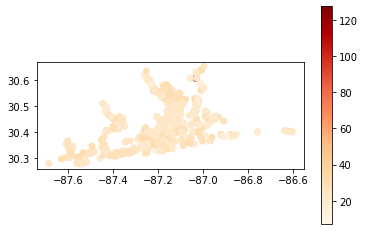

In [6]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(df_wide, stations_gdf, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

##### import the required libraries. Check requirements.txt for dependencies that should be installed.

In [7]:
import os
import pandas
import geopandas
from harmonize_wq import harmonize
from harmonize_wq import convert
from harmonize_wq import wrangle
from harmonize_wq import clean
import dataretrieval.wqp as wqp

#### Download location data using dataretrieval

In [8]:
from harmonize_wq import wrangle
from harmonize_wq import location
from harmonize_wq import visualize
from harmonize_wq import harmonize
from harmonize_wq import clean
import dataretrieval.wqp as wqp

<AxesSubplot:>

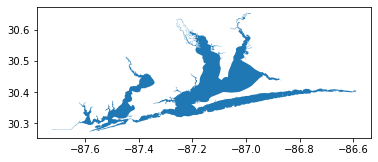

In [9]:
# Read geometry for Area of Interest from test data or local file
#aoi_url = r'https://github.com/USEPA/harmonize-wq/raw/master/harmonize_wq/tests/data/PPBays_NCCA.geojson'
aoi_url = r'D:\code\harmonize-wq\harmonize_wq\tests\data\PPBays_NCCA.geojson'  #Local file (temporary)
aoi_gdf = wrangle.as_gdf(aoi_url)

# Map aoi
aoi_gdf.plot()

In [10]:
# Note there are actually two polygons (one for each Bay)
aoi_gdf

,OBJECTID,EDACDA_NM,Shape_Length,Shape_Area,geometry
0,1,Pensacola Bay,707182.986461,4.944393e+08,"MULTIPOLYGON (((-87.25782 30.40920, -87.25737 ..."
1,2,Perdido Bay,308096.385352,1.352332e+08,"POLYGON ((-87.44271 30.51168, -87.44279 30.512..."


In [11]:
# Spatial query parameters (Note: first poly only)
bBox = wrangle.get_bounding_box(aoi_gdf, 0)

In [12]:
# Build query
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [13]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [14]:
# Rows and columns for results
stations.shape

(1974, 37)

In [15]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,AquiferName,LocalAqfrName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-AL,USGS Alabama Water Science Center,USGS-02376115,"ELEVENMILE CREEK NR WEST PENSACOLA, FL",Stream,NaN,3140107.0,27.8,sq mi,27.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-FL,USGS Florida Water Science Center,USGS-02367320,EAST BAY RIVER NR WYNNEHAVEN BEACH FL,Stream,NaN,3140105.0,62.0,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-FL,USGS Florida Water Science Center,USGS-02367377,LIGHTWOOD KNOT CREEK AT LONGWOOD FL,Stream,NaN,3140102.0,11.8,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-FL,USGS Florida Water Science Center,USGS-02367388,"TURTLE CREEK NR FT WALTON BEACH, FL",Stream,NaN,3140105.0,14.3,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-FL,USGS Florida Water Science Center,USGS-02367390,TURTLE CREEK NEAR OCEAN CITY FL,Stream,NaN,3140105.0,22.3,sq mi,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [16]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName        NAD83
LatitudeMeasure                                 30.498252
LongitudeMeasure                               -87.335809
Name: 0, dtype: object

In [17]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = location.harmonize_locations(stations, out_EPSG=4326, intermediate_columns=True)

In [18]:
location.harmonize_locations?

In [19]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(1974, 42)

In [20]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig                (-87.3358086, 30.49825159)
EPSG                                         4269.0
QA_flag                                         NaN
geom         POINT (-87.33580859999999 30.49825159)
geometry     POINT (-87.33580859999999 30.49825159)
Name: 0, dtype: object

In [21]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [22]:
# Look at QA_flag for one w/ bad datum
stations_gdf.loc[stations_gdf['QA_flag'].notna()].iloc[0]['QA_flag']

'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'

<AxesSubplot:>

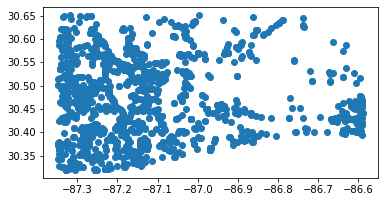

In [23]:
stations_gdf.plot()

In [24]:
# Clip to area of interest
aoi_gdf.to_crs(4326, inplace=True)
stations_clipped = wrangle.clip_stations(stations_gdf, aoi_gdf)

<AxesSubplot:>

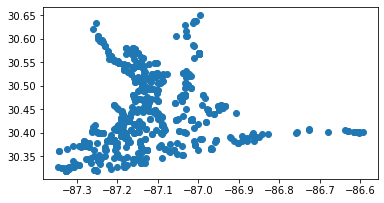

In [25]:
# Map it
stations_clipped.plot()

In [26]:
# How many stations now?
len(stations_clipped)

1030

In [27]:
# To save the results to a shapefile
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'PPBEP_stations.shp'))

#### Retrieve Characteristic Data

In [28]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\ipykernel_launcher.py:3: DtypeWarning: Columns (9,10,13,15,17,19,20,21,22,23,28,31,33,34,36,58,60,61,64,65,70,71,72,73) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1536988F1,2013-09-17,11:01:00,EST,21FLPNS_WQX-33030019,STORET-308146602,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520810L,2013-07-23,10:01:00,EST,21FLPNS_WQX-33020146,STORET-308157908,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLCBA_WQX,CHOCTAWHATCHEE BASIN ALLIANCE,21FLCBA_WQX-BAS219848-162813,2013-09-23,17:15:00,CST,21FLCBA_WQX-BAS02,STORET-760593202,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-028800618132,2013-06-18,11:01:00,EST,21FLSEAS_WQX-02SEAS880,STORET-310466105,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1558337F1,2013-12-01,13:01:00,EST,21FLBFA_WQX-33020LT2,STORET-291224060,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312533,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900924,1959-02-04,NaN,NaN,USGS-303745086442101,NWIS-99056232,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
312534,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,1958-01-14,09:20:00,CST,USGS-02376108,NWIS-6892104,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
312535,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,1958-01-14,09:20:00,CST,USGS-02376108,NWIS-6892108,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
312536,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900926,1959-02-05,NaN,NaN,USGS-303820086241802,NWIS-6917390,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


<AxesSubplot:>

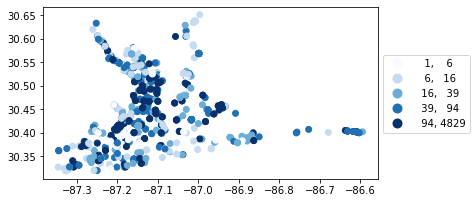

In [30]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(df, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [31]:
# See Documentation
#harmonize.harmonize_all?
#harmonize.harmonize_generic?

##### secchi disk depth

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    8997.000000
mean        1.126001
std         0.811803
min         0.000000
25%         0.569000
50%         1.000000
75%         1.400000
max         9.300000
dtype: float64
Unusable results: 17
Usable results with inferred units: 0
Results outside threshold (0.0 to 5.996816835973112): 17


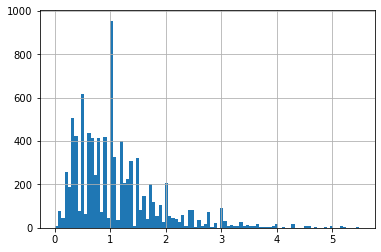

In [32]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize_generic(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [33]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
39,21FLPNS_WQX-33020JF1,0.60,m,NaN,m,0.6 meter
46,21FLGW_WQX-3565,.3,m,NaN,m,0.3 meter
50,21FLBFA_WQX-33010016,1.5,m,NaN,m,1.5 meter
98,21FLBFA_WQX-33010030,1.25,m,NaN,m,1.25 meter
103,21FLBFA_WQX-33030019,1.3,m,NaN,m,1.3 meter
...,...,...,...,...,...,...
312370,21FLPNS_WQX-G4NW0520,1.2,m,NaN,m,1.2 meter
312376,21FLPNS_WQX-G4NW0518,1.729,m,NaN,m,1.729 meter
312380,21FLPNS_WQX-3302J2GS4,2.5,m,NaN,m,2.5 meter
312385,21FLPNS_WQX-G4NW0441,0.8,m,NaN,m,0.8 meter


In [34]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
124356,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
126049,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
126436,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
129344,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
130324,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
131491,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
131956,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
133758,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
227242,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
228653,21FLKWAT_WQX-OKA-CB-SANROS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


In [35]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [36]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
124356,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
126049,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
126436,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
129344,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
130324,21FLKWAT_WQX-OKA-CBA-GAP-3-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
131491,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
131956,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
133758,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
227242,21FLKWAT_WQX-OKA-CB-BASS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
228653,21FLKWAT_WQX-OKA-CB-SANROS-1,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN


All these were missing both a value and unit so nothing could be done

In [37]:
# Aggregate Secchi data by station
visualize.summary_table(sechi_results, 'Secchi')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_CMP_PKT03,3,2.333333
1,21FLBFA_WQX-33010011,21,0.278571
2,21FLBFA_WQX-33010016,83,1.496386
3,21FLBFA_WQX-33010021,71,0.964789
4,21FLBFA_WQX-33010030,66,1.096212
...,...,...,...
635,NARS_WQX-NCCA10-1431,1,2.500000
636,NARS_WQX-NCCA10-1432,1,1.075000
637,NARS_WQX-NCCA10-1433,1,1.423333
638,NARS_WQX-NCCA10-1434,1,2.400000


<AxesSubplot:>

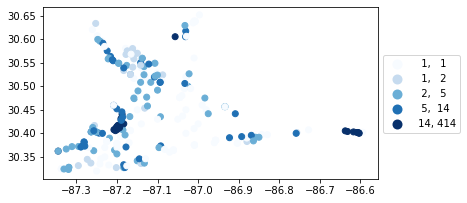

In [38]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(sechi_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

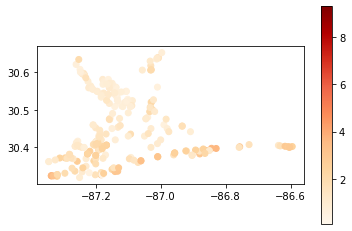

In [39]:
# Map average secchi depth results at each station
gdf_avg = visualize.map_measure(sechi_results, stations_clipped, 'Secchi')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    62178.000000
mean        21.666167
std         11.394238
min        -12.944444
25%         16.666667
50%         21.833333
75%         26.960000
max       1876.000000
dtype: float64
Unusable results: 1
Usable results with inferred units: 10
Results outside threshold (0.0 to 90.03159297156438): 7


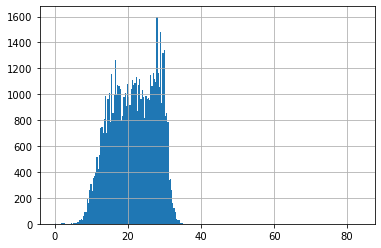

In [40]:
#'Temperature, water'
# errors=‘ignore’, invalid dimension conversions will return the NaN.
df = harmonize.harmonize_generic(df, 'Temperature, water', intermediate_columns=True, report=True, errors='ignore')

In [41]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,21FLCBA_WQX-BAS02,78.9,deg F,NaN,26.0555555555556 degree_Celsius,degF
17,21FLPNS_WQX-33030019,23.12,deg C,NaN,23.12 degree_Celsius,degC
28,21FLPNS_WQX-330300G9,16.43,deg C,NaN,16.43 degree_Celsius,degC
32,21FLCBA_WQX-BAS01,83.8,deg F,NaN,28.77777777777783 degree_Celsius,degF
33,21FLPNS_WQX-33030011,20.26,deg C,NaN,20.26 degree_Celsius,degC
...,...,...,...,...,...,...
312523,USGS-302420087140301,23.0,deg C,NaN,23.0 degree_Celsius,degC
312525,USGS-302703087133501,24.0,deg C,NaN,24.0 degree_Celsius,degC
312528,USGS-303733086441001,22.2,deg C,NaN,22.2 degree_Celsius,degC
312531,USGS-302703087133502,24.0,deg C,NaN,24.0 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [42]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
151746,21FLCBA-FWB05,79.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.8 degree_Celsius,degC
151801,21FLCBA-FWB05,81.7,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",81.7 degree_Celsius,degC
152679,21FLCBA-FWB02,82.1,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.1 degree_Celsius,degC
152680,21FLCBA-FWB02,82.6,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",82.6 degree_Celsius,degC
152681,21FLCBA-FWB02,71.8,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",71.8 degree_Celsius,degC
152682,21FLCBA-FWB02,79.4,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",79.4 degree_Celsius,degC
158254,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
158255,21FLCBA-RIV02,74.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",74.2 degree_Celsius,degC
162654,21FLCBA-FWB01,83.3,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",83.3 degree_Celsius,degC
162738,21FLCBA-FWB01,71.2,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",71.2 degree_Celsius,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [43]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [44]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
45767,11NPSWRD_WQX-GUIS_NALO,NaN,deg C,ResultMeasureValue: missing (NaN) result,NaN,degC


In [45]:
# Aggregate temperature data by station
visualize.summary_table(temperature_results, 'Temperature')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_BCCA,1,36.80000
1,11NPSWRD_WQX-GUIS_BISA,32,22.69625
2,11NPSWRD_WQX-GUIS_BOPI,1,32.00000
3,11NPSWRD_WQX-GUIS_CMP_PKT03,2,30.25000
4,11NPSWRD_WQX-GUIS_FPPO,1,34.70000
...,...,...,...
1710,USGS-303853087164401,1,23.00000
1711,USGS-303853087200501,1,20.00000
1712,USGS-303857087163501,1,22.00000
1713,USGS-303859087200301,1,17.50000


<AxesSubplot:>

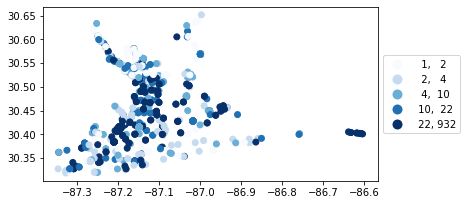

In [46]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(temperature_results, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

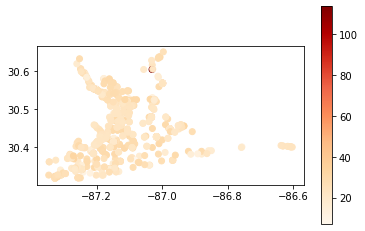

In [47]:
# Map average temperature results at each station
gdf_temperature = visualize.map_measure(temperature_results, stations_clipped, 'Temperature')
gdf_temperature.plot(column='mean', cmap='OrRd', legend=True)

###### Dissolved oxygen

In [48]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize_generic(df, 'Dissolved oxygen (DO)')

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [49]:
# Look at what was changed
cols = ['MonitoringLocationIdentifier', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
7,21FLPNS_WQX-33030D71,6.64,mg/l,NaN,6.64 milligram / liter
15,21FLCBA_WQX-SRS03,6.28,mg/l,NaN,6.28 milligram / liter
16,21FLPNS_WQX-33020K20,4.53,mg/l,NaN,4.53 milligram / liter
19,21FLPNS_WQX-33030019,9.32,mg/l,NaN,9.32 milligram / liter
22,21FLCMP_WQX-3201BM21,4.5,mg/l,NaN,4.5 milligram / liter
...,...,...,...,...,...
312433,FWCLOCAL-03140105-BB-03,7.3,mg/l,NaN,7.3 milligram / liter
312437,FWCLOCAL-03140105-BB-01,10.2,mg/l,NaN,10.2 milligram / liter
312438,FWCLOCAL-03140105-BB-01,8.1,mg/l,NaN,8.1 milligram / liter
312443,FWCLOCAL-03140104-BR-11,7.4,mg/l,NaN,7.4 milligram / liter


In [50]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,MonitoringLocationIdentifier,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
151739,21FLCBA-FWB05,6.61,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",6.61 milligram / liter
151747,21FLCBA-FWB05,5.83,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",5.83 milligram / liter
152564,21FLCBA-FWB02,6.6,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",6.6 milligram / liter
152565,21FLCBA-FWB02,5.37,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",5.37 milligram / liter
152641,21FLCBA-FWB02,6.75,NaN,"ResultMeasure/MeasureUnitCode: MISSING UNITS, ...",6.75 milligram / liter
...,...,...,...,...,...
278891,11NPSWRD_WQX-GUIS_UWF_FPICKN,8.4,ppm,NaN,6.940359231119999e-05 milligram / liter
278900,11NPSWRD_WQX-GUIS_UWF_FPICKN,7.35,ppm,NaN,6.072814327229999e-05 milligram / liter
278904,11NPSWRD_WQX-GUIS_UWF_FPICKN,7.29,ppm,NaN,6.023240332721999e-05 milligram / liter
278918,11NPSWRD_WQX-GUIS_UWF_FPICKN,9.12,ppm,NaN,7.535247165215999e-05 milligram / liter


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [51]:
# Aggregate DO data by station
visualize.summary_table(do_res, 'DO')

,MonitoringLocationIdentifier,cnt,mean
0,11NPSWRD_WQX-GUIS_BCCA,1,0.270000
1,11NPSWRD_WQX-GUIS_BISA,32,7.194375
2,11NPSWRD_WQX-GUIS_BOPI,1,7.540000
3,11NPSWRD_WQX-GUIS_FPPO,1,9.950000
4,11NPSWRD_WQX-GUIS_FPPT,1,6.880000
...,...,...,...
1482,NARS_WQX-NCCA10-1432,8,6.075000
1483,NARS_WQX-NCCA10-1433,16,6.931250
1484,NARS_WQX-NCCA10-1434,26,6.280769
1485,NARS_WQX-NCCA10-2432,12,6.650000


<AxesSubplot:>

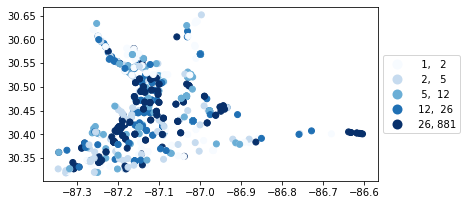

In [52]:
# Map number of usable results at each station
gdf_count = visualize.map_counts(do_res, stations_clipped)
gdf_count.plot(column='cnt', cmap='Blues', legend=True, scheme='quantiles', legend_kwds={"fmt": "{:.0f}", 'bbox_to_anchor':(1, 0.75)})

<AxesSubplot:>

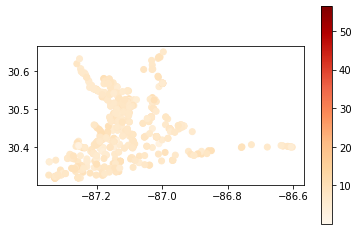

In [53]:
# Map Averages at each station
gdf_avg = visualize.map_measure(do_res, stations_clipped, 'DO')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)

###### pH

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    41550.000000
mean         7.421859
std          0.867783
min          0.500000
25%          7.000000
50%          7.720000
75%          8.000000
max         16.200000
dtype: float64
Unusable results: 51
Usable results with inferred units: 29
Results outside threshold (0.0 to 12.628557365887833): 1


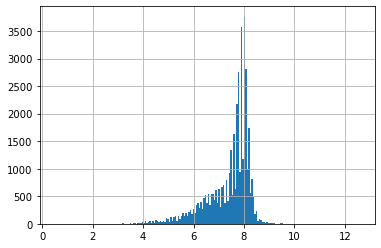

In [54]:
# pH, this time looking at a report
df = harmonize.harmonize_generic(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [55]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
0,7.29,None,NaN,7.29 dimensionless
10,6.57,None,NaN,6.57 dimensionless
11,6.57,None,NaN,6.57 dimensionless
13,7.72,None,NaN,7.72 dimensionless
18,6.2,None,NaN,6.2 dimensionless
...,...,...,...,...
312532,5.9,std units,NaN,5.9 dimensionless
312533,7.9,std units,NaN,7.9 dimensionless
312535,8.3,std units,NaN,8.3 dimensionless
312536,6.6,std units,NaN,6.6 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

###### Salinity

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    56154.000000
mean        16.739560
std        172.049569
min          0.000000
25%          7.200000
50%         17.000000
75%         23.830000
max      37782.000000
dtype: float64
Unusable results: 400
Usable results with inferred units: 10
Results outside threshold (0.0 to 1049.0369735267054): 3


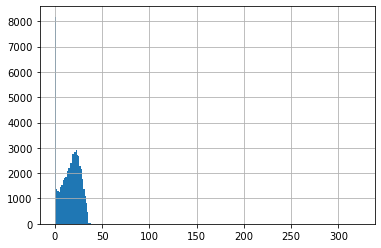

In [56]:
# Salinity
df = harmonize.harmonize_generic(df, 'Salinity', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
4,18.9,ppth,NaN,18.9 Practical_Salinity_Units
6,11.82,ppth,NaN,11.82 Practical_Salinity_Units
12,0.50,ppth,NaN,0.5 Practical_Salinity_Units
14,3.3,ppth,NaN,3.3 Practical_Salinity_Units
24,21.43,ppth,NaN,21.43 Practical_Salinity_Units
...,...,...,...,...
312397,4.97,ppth,NaN,4.97 Practical_Salinity_Units
312403,18.03,ppth,NaN,18.03 Practical_Salinity_Units
312404,16.93,ppth,NaN,16.93 Practical_Salinity_Units
312407,18.72,ppth,NaN,18.72 Practical_Salinity_Units


###### Nitrogen

D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'cm3/g' UNDEFINED UNIT for Nitrogen
  warn("WARNING: " + problem)
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count      59.000000
mean       39.927749
std       213.320030
min         0.000700
25%         0.343605
50%         0.486780
75%         1.600000
max      1630.000000
dtype: float64
Unusable results: 4
Usable results with inferred units: 0
Results outside threshold (0.0 to 1319.8479306182717): 1


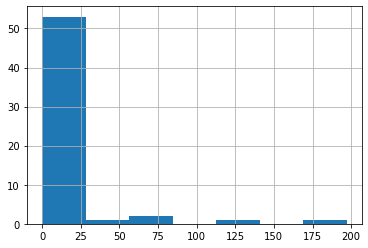

In [58]:
# Nitrogen
df = harmonize.harmonize_generic(df, 'Nitrogen', report=True)

In [59]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
42309,0.3,mg/l,NaN,0.3 milligram / liter
42467,0.36,mg/l,NaN,0.36 milligram / liter
42573,0.33875,mg/l,NaN,0.33875 milligram / liter
43065,135,mg/kg,NaN,135.00000000000003 milligram / liter
43272,0.4075,mg/l,NaN,0.4075 milligram / liter
...,...,...,...,...
311791,17.61,mg/l,NaN,17.61 milligram / liter
311827,0.0007,cm3/g STP,ResultMeasure/MeasureUnitCode: 'cm3/g' UNDEFIN...,0.0007 milligram / liter
311829,0.0146,cm3/g @STP,ResultMeasure/MeasureUnitCode: 'cm3/g' UNDEFIN...,0.0146 milligram / liter
311835,0.0008,cm3/g STP,ResultMeasure/MeasureUnitCode: 'cm3/g' UNDEFIN...,0.0008 milligram / liter


###### Conductivity

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count      2.00000
mean     126.20000
std       60.52834
min       83.40000
25%      104.80000
50%      126.20000
75%      147.60000
max      169.00000
dtype: float64
Unusable results: 7
Usable results with inferred units: 0
Results outside threshold (0.0 to 489.37004281741076): 0


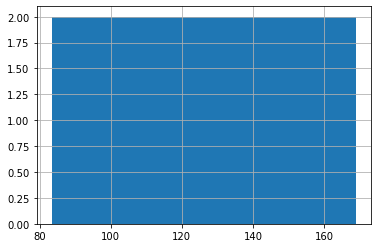

In [60]:
df = harmonize.harmonize_generic(df, 'Conductivity', report=True)

Note: No report because too few results

In [61]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
22556,169,uS/cm,NaN,169.0 microsiemens / centimeter
90699,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
91213,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
92242,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
92291,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
93943,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
94952,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
96412,NaN,uS/cm,ResultMeasureValue: missing (NaN) result,NaN
124867,83.4,uS/cm,NaN,83.4 microsiemens / centimeter


###### Chlorophyll a

D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'ug/cm2' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:154: UserWarning: WARNING: 'None' UNDEFINED UNIT for Chlorophyll
  warn("WARNING: " + problem)
D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    8116.000000
mean        1.292809
std         1.185580
min        -0.840000
25%         0.021000
50%         1.160000
75%         1.960000
max         9.990000
dtype: float64
Unusable results: 183
Usable results with inferred units: 0
Results outside threshold (0.0 to 8.406291844277193): 8


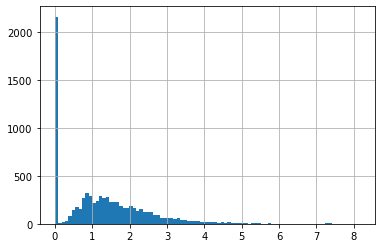

In [62]:
# Chlorophyll a
df = harmonize.harmonize_generic(df, 'Chlorophyll a', report=True)

In [63]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
29425,0.436969697,ug/cm2,ResultMeasure/MeasureUnitCode: 'ug/cm2' UNDEFI...,0.436969697 milligram / liter
42627,5.87,ug/l,NaN,0.00587 milligram / liter
44328,2.86,ug/l,NaN,0.00286 milligram / liter
44359,10.69,ug/l,NaN,0.01069 milligram / liter
45134,2.69,ug/l,NaN,0.00269 milligram / liter
...,...,...,...,...
240570,3,ug/l,NaN,0.003 milligram / liter
240571,10,ug/l,NaN,0.01 milligram / liter
240572,3,ug/l,NaN,0.003 milligram / liter
240573,2,ug/l,NaN,0.002 milligram / liter


###### Organic Carbon

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count      3299.000000
mean       1145.173762
std       12759.139716
min           0.000000
25%           2.600000
50%           4.100000
75%           8.200000
max      410000.000000
dtype: float64
Unusable results: 104
Usable results with inferred units: 0
Results outside threshold (0.0 to 77700.01205688257): 18


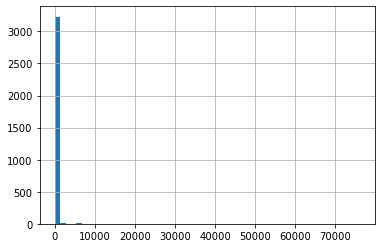

In [64]:
# Organic carbon (%)
df = harmonize.harmonize_generic(df, 'Organic carbon', report=True)

In [65]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
95,2.6,mg/l,NaN,2.6 milligram / liter
133,5.2,mg/l,NaN,5.2 milligram / liter
135,3.6,mg/l,NaN,3.6 milligram / liter
167,3.9,mg/l,NaN,3.9 milligram / liter
235,2.6,mg/l,NaN,2.6 milligram / liter
...,...,...,...,...
312268,2.8,mg/l,NaN,2.8 milligram / liter
312303,6.0,mg/l,NaN,6.0 milligram / liter
312305,1.2,mg/l,NaN,1.2 milligram / liter
312329,3.7,mg/l,NaN,3.7 milligram / liter


###### Turbidity

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    32414.000000
mean         8.134691
std        209.069707
min         -0.047700
25%          1.400000
50%          2.400000
75%          4.600000
max      32342.452300
dtype: float64
Unusable results: 138
Usable results with inferred units: 10
Results outside threshold (0.0 to 1262.5529335657106): 20


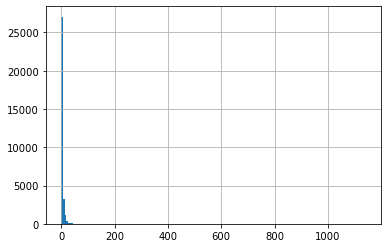

In [66]:
# Turbidity (NTU)
df = harmonize.harmonize_generic(df, 'Turbidity', report=True)

In [67]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
9,0,NTU,NaN,0.0 Nephelometric_Turbidity_Units
40,5.6,NTU,NaN,5.6 Nephelometric_Turbidity_Units
42,28,NTU,NaN,28.0 Nephelometric_Turbidity_Units
70,4.7,NTU,NaN,4.7 Nephelometric_Turbidity_Units
100,4.6,NTU,NaN,4.6 Nephelometric_Turbidity_Units
...,...,...,...,...
312447,10.0,NTU,NaN,10.0 Nephelometric_Turbidity_Units
312448,10.0,NTU,NaN,10.0 Nephelometric_Turbidity_Units
312459,0.0,JTU,NaN,-0.0477 Nephelometric_Turbidity_Units
312478,50.0,JTU,NaN,951.2022999999999 Nephelometric_Turbidity_Units


###### Sediment

In [68]:
# Sediment
df = harmonize.harmonize_generic(df, 'Sediment', report=False)

In [69]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
311807,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
311821,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


###### Phosphorus

In [70]:
# Phosphorus
# Note: must be merged w/ activities (package runs query by site if not already merged)
df = harmonize.harmonize_generic(df, 'Phosphorus')

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values
D:\code\harmonize-wq\harmonize_wq\harmonize.py:432: UserWarning: Warning: "Filterable_Phosphorus" column for Filterable, may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:432: UserWarning: Warning: "Total_Recoverable_Phosphorus" column for Total Recoverable, may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:432: UserWarning: Warning: "Bed_Sediment_Phosphorus" column for Bed Sediment, may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:432: UserWarning: Warning: "Non-Filterable_(Particle)_Phosphorus" column for Non-Filterable (Particle), may be error
  warn('Warning: ' + prob)
D:\code\harmonize-wq\harmonize_wq\harmonize.py:432: UserWarning: Warning: "__Phosphorus" column for  , m

Note the warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [71]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
2791,0.019,mg/l,NaN,0.019 milligram / liter
6254,0.002,mg/l,NaN,0.002 milligram / liter
24418,0.003,mg/l,NaN,0.003 milligram / liter
26700,0.019,mg/l,NaN,0.019 milligram / liter
86674,0.002,mg/l,NaN,0.002 milligram / liter
87875,0.017,mg/l,NaN,0.017 milligram / liter
90313,0.021,mg/l,NaN,0.021 milligram / liter
92155,0.003,mg/l,NaN,0.003 milligram / liter
102764,0.020,mg/l,NaN,0.02 milligram / liter
107471,0.002,mg/l,NaN,0.002 milligram / liter


In [72]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TP_Phosphorus']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TP_Phosphorus
121,0.003,mg/l,NaN,0.003 milligram / liter
272,0.002,mg/l,NaN,0.002 milligram / liter
304,0.020,mg/l,NaN,0.02 milligram / liter
1959,0.033,mg/l,NaN,0.033 milligram / liter
2144,0.003,mg/l,NaN,0.003 milligram / liter
...,...,...,...,...
312352,0.023,mg/l,NaN,0.023 milligram / liter
312357,0.038,mg/l,NaN,0.038 milligram / liter
312363,0.008,mg/l,NaN,0.008 milligram / liter
312384,0.009,mg/l,NaN,0.009 milligram / liter


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count    34736.000000
mean       117.185398
std        625.704648
min          0.000000
25%          4.000000
50%         14.000000
75%         62.000000
max      50500.000000
dtype: float64
Unusable results: 9254
Usable results with inferred units: 0
Results outside threshold (0.0 to 3871.4132835010796): 99


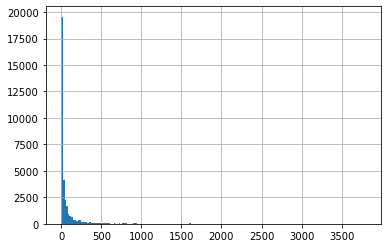

In [73]:
df = harmonize.harmonize_generic(df, 'Fecal Coliform', report=True)

In [74]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
1,80,cfu/100ml,NaN,80.0 Colony_Forming_Units / milliliter
3,2,MPN/100ml,NaN,2.0 Colony_Forming_Units / milliliter
5,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
8,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
21,40,cfu/100ml,NaN,40.0 Colony_Forming_Units / milliliter
...,...,...,...,...
311356,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
311390,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN
311910,4.0,cfu/100ml,NaN,4.0 Colony_Forming_Units / milliliter
312018,1.0,cfu/100ml,NaN,1.0 Colony_Forming_Units / milliliter


###### Escherichia coli

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


-Usable results-
count     1815.000000
mean       507.145014
std       1484.966477
min          4.100000
25%         86.000000
50%        187.000000
75%        384.000000
max      24200.000000
dtype: float64
Unusable results: 9
Usable results with inferred units: 0
Results outside threshold (0.0 to 9416.943877420326): 11


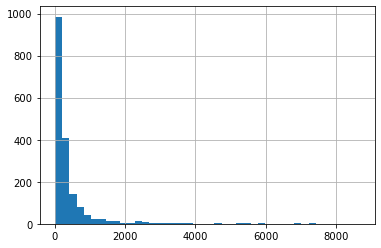

In [75]:
df = harmonize.harmonize_generic(df, 'Escherichia coli', report=True)

In [76]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
1653,44,#/100ml,NaN,44.0 Colony_Forming_Units / milliliter
2001,270,#/100ml,NaN,270.0 Colony_Forming_Units / milliliter
2125,120,#/100ml,NaN,120.0 Colony_Forming_Units / milliliter
2328,92,#/100ml,NaN,92.0 Colony_Forming_Units / milliliter
2921,740,#/100ml,NaN,740.0 Colony_Forming_Units / milliliter
...,...,...,...,...
312148,63.0,MPN/100ml,NaN,63.0 Colony_Forming_Units / milliliter
312160,31.0,MPN/100ml,NaN,31.0 Colony_Forming_Units / milliliter
312247,201.0,MPN/100ml,NaN,201.0 Colony_Forming_Units / milliliter
312306,110.0,MPN/100ml,NaN,110.0 Colony_Forming_Units / milliliter


### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

In [77]:
from harmonize_wq import convert

There are not enough conductivity results to demonstrate this fully in pensacola Bay. We'll mainly just explore Salinity results.

In [78]:
#Notes:
#df[df['Conductivity'].notna(), 'Salinity'] = df[df['Conductivity'].notna()].apply(convert.conductivity_to_PSU)
#df['Conductivity'].dropna().equals(df[df['Conductivity'].notna()]['Conductivity'])

In [79]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: 0.0 to 37782.0
Results: 56154 
Mean: 16.739559746411587 PSU


In [80]:
# Identify extreme outliers
[x for x in lst if x >3200]

[15030.0, 37782.0]

In [81]:
# Look at important fields for max value
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
salinity_series = df['Salinity'][df['Salinity'].notna()]
x = max(salinity_series)
idx = df[df['Salinity']==x].index
df[cols][df['Salinity']==x]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
38285,37782,ppth,NaN,37782.0 Practical_Salinity_Units


In [82]:
# Look at important fields for second max value
x2 = max(salinity_series.drop(index=idx))
df[cols][df['Salinity']==x2]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
23391,15030,ppt,NaN,15030.0 Practical_Salinity_Units


Nothing jumps out as problematic for either value

In [83]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

22556     169.0 microsiemens / centimeter
124867     83.4 microsiemens / centimeter
Name: Conductivity, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm. The value we have is well within that.

In [84]:
# Check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
22556,169,uS/cm,NaN,NaN,169.0 microsiemens / centimeter
124867,83.4,uS/cm,NaN,NaN,83.4 microsiemens / centimeter


In [85]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

22556     0.083 dimensionless
124867    0.044 dimensionless
Name: Salinity, dtype: object

0.083 is close to expected PSU

### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [86]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
0,2013-09-17,11:01:00,EST
1,2013-07-23,10:01:00,EST
2,2013-09-23,17:15:00,CST
3,2013-06-18,11:01:00,EST
4,2013-12-01,13:01:00,EST
...,...,...,...
312533,1959-02-04,NaN,NaN
312534,1958-01-14,09:20:00,CST
312535,1958-01-14,09:20:00,CST
312536,1959-02-05,NaN,NaN


In [87]:
# Note the input columns are dropped (rename the result to preserve these columns)
df = clean.datetime(df)
df[['StartDate', 'Activity_datetime']]

,StartDate,Activity_datetime
0,2013-09-17,2013-09-17 16:01:00+00:00
1,2013-07-23,2013-07-23 15:01:00+00:00
2,2013-09-23,2013-09-23 23:15:00+00:00
3,2013-06-18,2013-06-18 16:01:00+00:00
4,2013-12-01,2013-12-01 18:01:00+00:00
...,...,...
312533,1959-02-04,NaT
312534,1958-01-14,1958-01-14 15:20:00+00:00
312535,1958-01-14,1958-01-14 15:20:00+00:00
312536,1959-02-05,NaT


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a startDate column is used to preserve date only.

### Depth

In [88]:
# Depth of sample (default units='meter')
df = clean.harmonize_depth(df)
#df.loc[df['ResultDepthHeightMeasure/MeasureValue'].dropna(), "Depth"]
df['ResultDepthHeightMeasure/MeasureValue'].dropna()

D:\Python\env\arcgispro-py3-spy-harmonize-wq\lib\site-packages\pandas\core\dtypes\cast.py:1990: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  result[:] = values


90276    0.1
90309    2.2
90358    2.0
90436    1.0
90464    3.0
        ... 
96412    0.1
96422    0.5
96475    1.3
96483    2.0
96501    2.2
Name: ResultDepthHeightMeasure/MeasureValue, Length: 173, dtype: float64

Data are often lacking sample depth metadata, even this small number including depth is good

### Characteristic to Column (long to wide format)

In [89]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,MethodSpecificationName,CharacteristicName,ResultSampleFractionText,...,QA_Unfiltered_Phosphorus,QA_Fecal_Coliform,QA_Conductivity,QA_Nitrogen,QA_E_coli,QA_Carbon,QA_Chlorophyll,QA_Sediment,QA_Temperature,QA_DO
0,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1536988F1,21FLPNS_WQX-33030019,STORET-308146602,NaN,NaN,NaN,pH,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520810L,21FLPNS_WQX-33020146,STORET-308157908,NaN,NaN,NaN,Fecal Coliform,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21FLCBA_WQX,CHOCTAWHATCHEE BASIN ALLIANCE,21FLCBA_WQX-BAS219848-162813,21FLCBA_WQX-BAS02,STORET-760593202,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-028800618132,21FLSEAS_WQX-02SEAS880,STORET-310466105,NaN,NaN,NaN,Fecal Coliform,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1558337F1,21FLBFA_WQX-33020LT2,STORET-291224060,NaN,NaN,NaN,Salinity,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312533,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900924,USGS-303745086442101,NWIS-99056232,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312534,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,USGS-02376108,NWIS-6892104,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312535,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800572,USGS-02376108,NWIS-6892108,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312536,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95900926,USGS-303820086241802,NWIS-6917390,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

16 new columns


In [91]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

10303 fewer rows


In [92]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [93]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [94]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier', 'ProviderName',
       'Secchi', 'Temperature', 'DO', 'pH', 'Salinity', 'Nitrogen',
       'Speciation', 'Conductivity', 'Chlorophyll', 'Carbon', 'Turbidity',
       'Sediment', 'Phosphorus', 'TP_Phosphorus', 'TDP_Phosphorus',
       'Bed_Sediment_Phosphorus', 'Unfiltered_Phosphorus', 'Fecal_Coliform',
       'E_coli', 'StartDate', 'Activity_datetime', 'Depth', 'QA_Salinity',
       'QA_Secchi', 'QA_pH', 'QA_Turbidity', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Bed_Sediment_Phosphorus',
       'QA_Unfiltered_Phosphorus', 'QA_Fecal_Coliform', 'QA_Conductivity',
       'QA_Nitrogen', 'QA_E_coli', 'QA_Carbon', 'QA_Chlorophyll',
       'QA_Sediment', 'QA_Temperature', 'QA_DO'],
      dtype='object')

In [95]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ProviderName,Secchi,Temperature,DO,pH,Salinity,...,QA_Unfiltered_Phosphorus,QA_Fecal_Coliform,QA_Conductivity,QA_Nitrogen,QA_E_coli,QA_Carbon,QA_Chlorophyll,QA_Sediment,QA_Temperature,QA_DO
0,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1536988F1,21FLPNS_WQX-33030019,STORET,NaN,NaN,NaN,7.29 dimensionless,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21FLPNS_WQX,"FL Dept. of Environmental Protection, Northwes...",21FLPNS_WQX-1520810L,21FLPNS_WQX-33020146,STORET,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21FLCBA_WQX,CHOCTAWHATCHEE BASIN ALLIANCE,21FLCBA_WQX-BAS219848-162813,21FLCBA_WQX-BAS02,STORET,NaN,26.0555555555556 degree_Celsius,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-028800618132,21FLSEAS_WQX-02SEAS880,STORET,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21FLBFA_WQX,"FL Dept of Environmental Protection , Bream Fi...",21FLBFA_WQX-1558337F1,21FLBFA_WQX-33020LT2,STORET,NaN,NaN,NaN,NaN,18.9 Practical_Salinity_Units,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['Sediment',
 'QA_Secchi',
 'QA_TP_Phosphorus',
 'QA_TDP_Phosphorus',
 'QA_Bed_Sediment_Phosphorus',
 'QA_Unfiltered_Phosphorus',
 'QA_Fecal_Coliform',
 'QA_Conductivity',
 'QA_E_coli',
 'QA_Carbon',
 'QA_Sediment']

<AxesSubplot:>

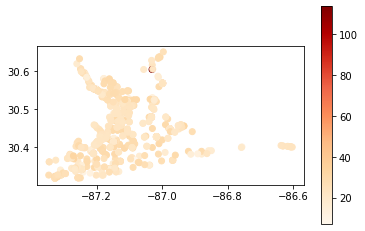

In [97]:
# Map average results at each station
gdf_avg = visualize.map_measure(main_df, stations_clipped, 'Temperature')
gdf_avg.plot(column='mean', cmap='OrRd', legend=True)